<a href="https://colab.research.google.com/github/Nishan-Charlie/e17-4yp-Applying-deep-learning-on-histological-images-of-lymph-tissues/blob/main/HER2_IHC_to_HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
import os
import shutil
import random
from tensorflow.keras.metrics import AUC
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [ ]:
base_ihc  = "/content/drive/MyDrive/Colab Notebooks/BCI_dataset/IHC"

In [ ]:
train_path = os.path.join(base_ihc, 'train')
# valid_path = os.path.join(base, 'valid')
test_path =  os.path.join(base_ihc, 'test')
print(len(os.listdir(train_path)))

4


In [ ]:
os.chdir(base_ihc)

if os.path.isdir('train/0') is False:
  os.makedirs('train/0')
  for i in range(4):
    os.makedirs('train/'+str(i))
    os.makedirs('test/'+str(i))



In [ ]:
# Use glob to find the image files
# train_image_files = glob.glob(os.path.join(base_ihc, "train/*.png"))
# valid_set = glob.glob(os.path.join(base_ihc, "test/*/*.png"))
# test_set, valid_set = train_test_split(test_image_files, test_size=0.5, random_state=42)
# print(len(valid_set))

In [ ]:
# # Iterate through the image files
# for image_file in valid_set:
#     # Extract the filename without the path
#     file_name = os.path.basename(image_file)

#     # Split the filename to get the number part (0, 1, 2, 3)
#     file_parts = file_name.split("_")
#     # print(file_parts)
#     if len(file_parts) == 3:
#         folder_name = file_parts[2].split(".")[0]  # Extract the number part
#         dest_folder = os.path.join(base_ihc, "test", folder_name)

#         # Create the destination folder if it doesn't exist
#         if not os.path.exists(dest_folder):
#             os.makedirs(dest_folder)

#         # Move the image to the corresponding folder
#         shutil.move(image_file, os.path.join(dest_folder, file_name))

In [ ]:
train_path = os.path.join(base_ihc, "train")
test_path = os.path.join(base_ihc, "test")
# valid_path = os.path.join(base_ihc, "valid")
classes = os.listdir(train_path)
print(classes)


['0', '3+', '2+', '1+']


In [ ]:
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.8,
    rotation_range=15,      # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    )

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rotation_range=15,
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformations
    horizontal_flip=True).flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32)
valid_batches = dataGenerator.flow_from_directory(directory= test_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')
test_batches = dataGenerator.flow_from_directory(directory = test_path, target_size=(224,224),classes = classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')

Found 3896 images belonging to 4 classes.
Found 780 images belonging to 4 classes.
Found 197 images belonging to 4 classes.


In [ ]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

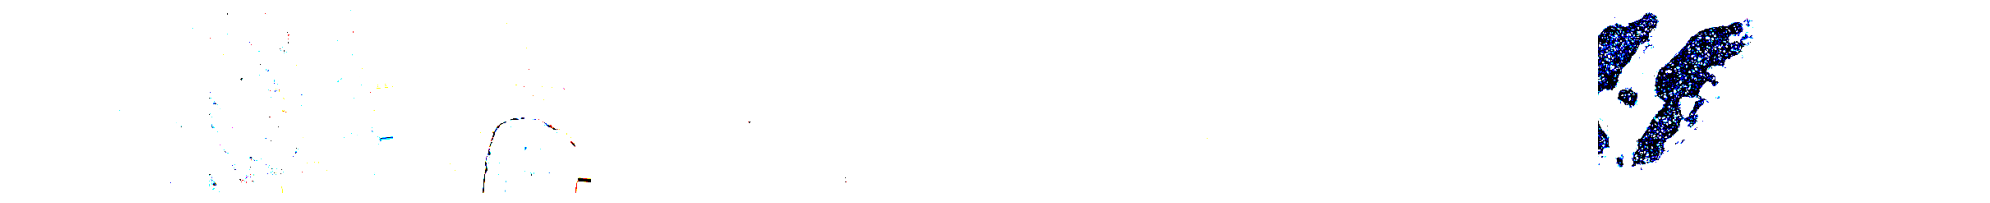

In [ ]:
imgs, labels = next(test_batches)
plotImages(imgs)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title='Confusin Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('flot')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i,j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

for layer in model.layers[:-3]:
  layer.trainable = False


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
# Add a dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))
model.add(Dense(units=256, activation = 'relu'))

model.add(Dense(units=4, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_data = train_batches[0][0]  # Access the first batch of data
batch_shape = batch_data.shape
print("Batch data shape:", batch_shape)

Batch data shape: (32, 224, 224, 3)


In [ ]:
train_batches.class_indices

{'0': 0, '3+': 1, '2+': 2, '1+': 3}

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 25)

Epoch 1/25
122/122 [==============================] - 1993s 16s/step - loss: 1.1636 - accuracy: 0.4730 - val_loss: 1.0164 - val_accuracy: 0.5244
Epoch 2/25
122/122 [==============================] - 103s 848ms/step - loss: 1.0119 - accuracy: 0.5403 - val_loss: 0.9413 - val_accuracy: 0.5744
Epoch 3/25
122/122 [==============================] - 102s 840ms/step - loss: 0.9374 - accuracy: 0.5637 - val_loss: 0.9218 - val_accuracy: 0.5526
Epoch 4/25
122/122 [==============================] - 102s 839ms/step - loss: 0.8792 - accuracy: 0.6024 - val_loss: 0.7871 - val_accuracy: 0.6667
Epoch 5/25
122/122 [==============================] - 102s 839ms/step - loss: 0.8284 - accuracy: 0.6204 - val_loss: 0.8300 - val_accuracy: 0.6551
Epoch 6/25
122/122 [==============================] - 106s 870ms/step - loss: 0.7909 - accuracy: 0.6496 - val_loss: 0.8169 - val_accuracy: 0.6538
Epoch 7/25
122/122 [==============================] - 103s 844ms/step - loss: 0.7493 - accuracy: 0.6573 - val_loss: 0.7771 - 

In [ ]:
model.save(base_ihc+"NEW_HER2Sample_VGG16")

In [ ]:

# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 26)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

test_loss, test_accuracy, AUC = model.evaluate(test_batches)
print("Testing Loss:", test_loss)
print("AUC", AUC)
print("Testing Accuracy:", test_accuracy)

In [ ]:

predictions =model.predict(x= test_batches, verbose=2)
cm = confusion_matrix(y_true= test_batches.classes, y_pred = np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title = 'Confusion Matrix of Her2 Sample VGG16')